# ZOD Dataset Exploration - Camera-Specific Pedestrian Prediction



In [1]:
from pathlib import Path # for file path operations
import os # for file path operations
from PIL import Image # for image processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import json
import numpy as np
import pandas as pd
#import seaborn as sns
import torch
import torchvision
from collections import Counter
import cv2
import random
from collections import defaultdict
import matplotlib.patches as patches
from math import sqrt



#### Establish paths to ZOD frames (original and ZOD256):

In [2]:
# This is the path to the ZOD256 dataset on the VM
# Its the ZOD dataset, cropped and resized it to 256x256. 
ZOD256_ROOT = Path("/mnt/pr_2018_scaleout_workdir/ZOD256/single_frames/")
# Path to original ZOD frames
ORIGINAL_ZOD_ROOT = Path("/home/edgelab/zod_dino_data/train2017/")
print("ZOD256_ROOT exists:", ZOD256_ROOT.exists())
print("ORIGINAL_ZOD_ROOT exists:", ORIGINAL_ZOD_ROOT.exists())




ZOD256_ROOT exists: True
ORIGINAL_ZOD_ROOT exists: True


## Dataset location and on-disk structure (local VM)

**Dataset root:** `/mnt/pr_2018_scaleout_workdir/ZOD256`

We will work with: 
- `single_frames` folder

### Frame folder structure, 100000 single frame directories:
`000000/`, ... , `099999/`

Each frame folder contains:
- `annotations/` — per-frame labels (e.g., 2D/3D boxes, segmentation, etc.)
- `camera_front_blur/` — anonymized camera image (blur)
- `camera_front_dnat/` — anonymized camera image (DNAT)
- `lidar_velodyne/` — LiDAR data for the keyframe

This exploration notebook focuses on **vision-only** using the front camera images
(`camera_front_blur` / `camera_front_dnat`) and the corresponding object labels
in `annotations/`, with emphasis on **pedestrians** and condition metadata.


### We will now compare the ZOD256 images with the original ones (images + annotations):

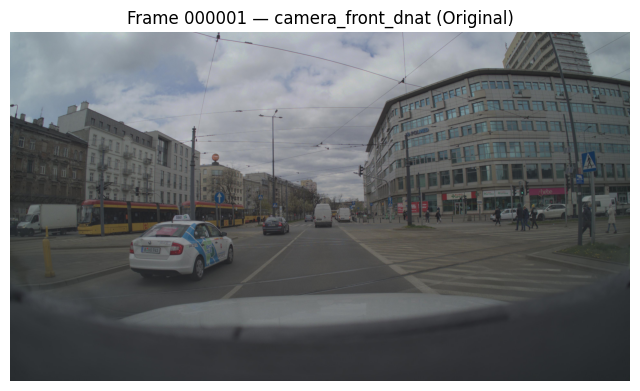

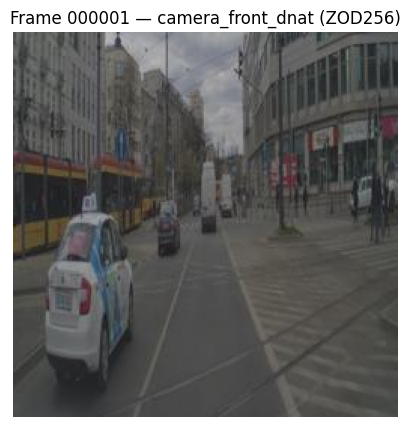

Original image size (W,H): (3848, 2168)
ZOD256 image size (W,H): (256, 256)


In [3]:
frame_id = "000001" # we look at the first frame in both datasets
# Now some visualization of the DNAT images in the two datasets:
ZOD256_second_frame_dir = ZOD256_ROOT / frame_id
ORIGINAL_second_frame_dir = ORIGINAL_ZOD_ROOT / frame_id
ZOD256_DNAT_DIR = ZOD256_second_frame_dir / "camera_front_dnat"
ORIGINAL_DNAT_DIR = ORIGINAL_second_frame_dir / "camera_front_dnat"

# Find the actual image files in these directories
zod256_dnat_files = list(ZOD256_DNAT_DIR.glob("*.jpg"))
original_dnat_files = list(ORIGINAL_DNAT_DIR.glob("*.jpg"))

# Check if files exist before trying to open them
if not zod256_dnat_files:
    raise FileNotFoundError(f"No .jpg files found in {ZOD256_DNAT_DIR}")
if not original_dnat_files:
    raise FileNotFoundError(f"No .jpg files found in {ORIGINAL_DNAT_DIR}")

# Read DNAT images (use the first file found)
ZOD256_DNAT_IMG = Image.open(zod256_dnat_files[0])
ORIGINAL_DNAT_IMG = Image.open(original_dnat_files[0])

# Display DNAT images
# Original DNAT image
plt.figure(figsize=(8, 5))
plt.imshow(ORIGINAL_DNAT_IMG)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat (Original)")
plt.show()

# ZOD256 DNAT image
plt.figure(figsize=(8, 5))
plt.imshow(ZOD256_DNAT_IMG)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat (ZOD256)")
plt.show()

# Image sizes pre/post resize:
print("Original image size (W,H):", ORIGINAL_DNAT_IMG.size)
print("ZOD256 image size (W,H):", ZOD256_DNAT_IMG.size)

### Visualize the crop (provided by Jonas) region on the original image

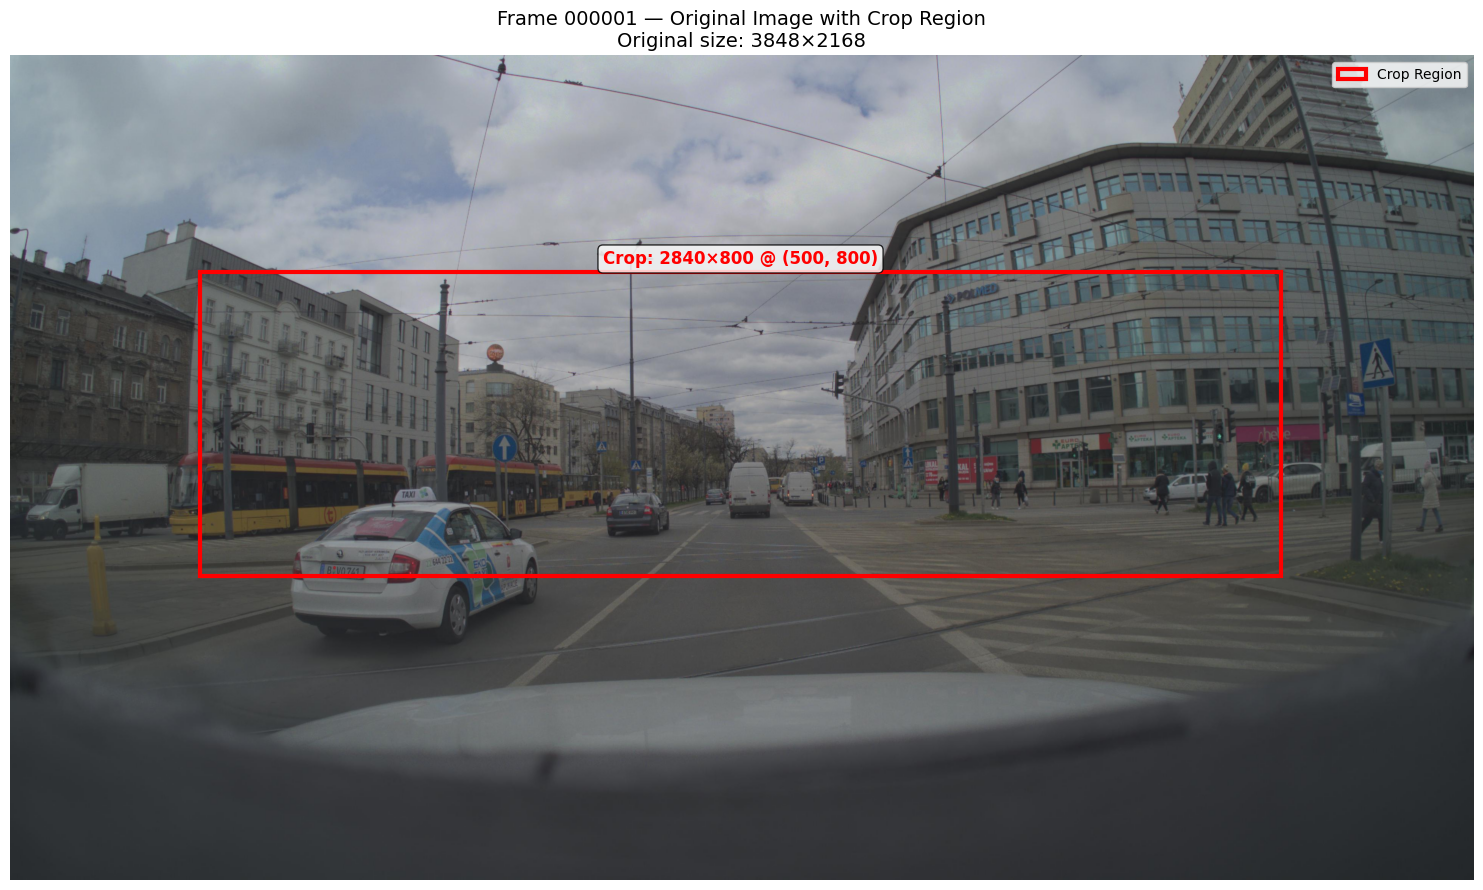

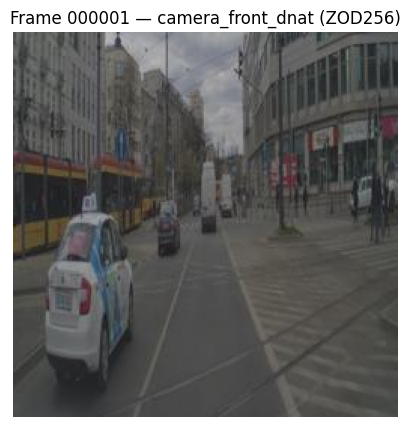

Crop region: left=500, top=800, width=2840, height=800
Crop region in original coordinates: (500, 800) to (3340, 1600)
Original image size: 3848×2168
Cropped region size: 2840×800


In [4]:
# Visualize the crop region on the original image
# Crop rectangle parameters (in original image coordinates):
#x-coordinate where the crop starts
crop_left = 500
#y-coordinate where the crop starts
crop_top = 800
#width of the crop
crop_width = 2840
#height of the crop
crop_height = 800

# Load second keyframe image
frame_id = "000001"
ORIGINAL_first_frame_dir = ORIGINAL_ZOD_ROOT / frame_id
ORIGINAL_DNAT_DIR = ORIGINAL_first_frame_dir / "camera_front_dnat"
original_dnat_files = list(ORIGINAL_DNAT_DIR.glob("*.jpg"))
original_img = Image.open(original_dnat_files[0])

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# Display the original image
ax.imshow(original_img)

# Create rectangle patch for the crop region
# Rectangle parameters: (left, bottom, width, height)
# Note: matplotlib uses bottom-left corner, but images use top-left
# So we need: (left, top from bottom, width, height)
# top from bottom = image_height - top - height
img_height = original_img.size[1]  # PIL uses (width, height)
rect_bottom = img_height - crop_top - crop_height

crop_rect = patches.Rectangle(
    (crop_left, rect_bottom),
    crop_width,
    crop_height,
    linewidth=3,
    edgecolor='red',
    facecolor='none',
    label='Crop Region'
)

ax.add_patch(crop_rect)

# Add text annotation
ax.text(
    crop_left + crop_width/2,
    rect_bottom - 20,
    f'Crop: {crop_width}×{crop_height} @ ({crop_left}, {crop_top})',
    color='red',
    fontsize=12,
    weight='bold',
    ha='center',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

ax.set_title(f"Frame {frame_id} — Original Image with Crop Region\nOriginal size: {original_img.size[0]}×{original_img.size[1]}", fontsize=14)
ax.axis("off")
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# ZOD256 DNAT image
plt.figure(figsize=(8, 5))
plt.imshow(ZOD256_DNAT_IMG)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat (ZOD256)")
plt.show()

print(f"Crop region: left={crop_left}, top={crop_top}, width={crop_width}, height={crop_height}")
print(f"Crop region in original coordinates: ({crop_left}, {crop_top}) to ({crop_left + crop_width}, {crop_top + crop_height})")
print(f"Original image size: {original_img.size[0]}×{original_img.size[1]}")
print(f"Cropped region size: {crop_width}×{crop_height}")



*Challenges*: 
- **Image Quality and object sizes**: It is no surprise that image quality is significantly worse in the ZOD256 dataset and pedestrians much harder to identify with the blind eye. This could provide a significant challenge for pedestrian prediction. 
- **Cropped images**: We see that quite a significant amount of the original image is cropped out, and we even observe that three pedestrians are excluded on the RHS. This provides another challenge, as we must ensure that annotations (pedestrian metadata) are appropriately modified to account for this crop. Pedestrian counts per image will differ, for example. 
- **Wrong crop**: We notice that the crop used in ZOD256 is not actually identical to that provided in the script provided by Jonas. Thus, perhaps the best option is to create a dataset from scratch and do the crop / resize ourselves. 

Hence: 
- Pedestrians are left out of crop --> must adjust count annotations along with bounding boxes.
- **ZOD256 preprocessing is undocumented and we therefore must pivot and instead create our own dataset from scratch and appropriately update metadata.**

#### We analyze frame-specific json files:

In [7]:

def read_json(path: Path):
    """
    Read a JSON file from disk and return it as a Python object.
    Parameters:
    - path: Path object pointing to a .json file
    Returns:
    - A Python dictionary or list (depending on the JSON content)
    """
    # first we open the file in read mode
    with open(path, "r") as file:

        # json.load reads JSON-formatted text from the file object 'file'
        # and converts it into native Python objects (dicts, lists, etc.)
        data = json.load(file)

    return data


# Read metadata describing environment conditions
ZOD256_second_frame_metadata = read_json(ZOD256_second_frame_dir / "metadata.json")
ORIGINAL_second_frame_metadata = read_json(ORIGINAL_second_frame_dir / "metadata.json")
#print(metadata)

# Read general info about the frame
ZOD256_first_frame_info = read_json(ZOD256_second_frame_dir / "info.json")
ORIGINAL_first_frame_info = read_json(ORIGINAL_first_frame_dir / "info.json")
#print(ZOD256_first_frame_info)
#print(ORIGINAL_first_frame_info)

print("metadata.json 000001 (keys: values)")
for k in ZOD256_second_frame_metadata.keys():
    print(f" - {k}: ZOD256={ZOD256_second_frame_metadata[k]}, ORIGINAL={ORIGINAL_second_frame_metadata[k]}")




metadata.json 000001 (keys: values)
 - frame_id: ZOD256=000001, ORIGINAL=000001
 - time: ZOD256=2021-04-27T10:51:26.001497Z, ORIGINAL=2021-04-27T10:51:26.001497Z
 - country_code: ZOD256=PL, ORIGINAL=PL
 - scraped_weather: ZOD256=partly-cloudy-day, ORIGINAL=partly-cloudy-day
 - collection_car: ZOD256=golf, ORIGINAL=golf
 - road_type: ZOD256=city, ORIGINAL=city
 - road_condition: ZOD256=normal, ORIGINAL=normal
 - time_of_day: ZOD256=day, ORIGINAL=day
 - num_lane_instances: ZOD256=4, ORIGINAL=4
 - num_vehicles: ZOD256=22, ORIGINAL=22
 - num_vulnerable_vehicles: ZOD256=9, ORIGINAL=9
 - num_pedestrians: ZOD256=19, ORIGINAL=19
 - num_traffic_lights: ZOD256=13, ORIGINAL=13
 - num_traffic_signs: ZOD256=19, ORIGINAL=19
 - longitude: ZOD256=21.043137452078366, ORIGINAL=21.043137452078366
 - latitude: ZOD256=52.249511324442636, ORIGINAL=52.249511324442636
 - solar_angle_elevation: ZOD256=51.72383270657507, ORIGINAL=51.72383270657507


#### We see that the metadata has not been adjusted at all despite the crop. 

- This is only problematic for fields with a count such as num_vehicles and num_pedestrians. That's okay for our purposes, since we will rely on *annotations/object_detection.json* for pedestrian counts instead. We will however check for consistency in count data across metadata.json / object_detection.json. 

- Note that info.json is a file with a bunch of file paths, which we will not use. 

### Annotations
Each annotation is referenced via a relative filepath under:
single_frames/000000/annotations/

- Object detection
- Lane markings
- Traffic signs
- Road condition


### LiDAR frames
- Sequence of Velodyne LiDAR scans at ~10 Hz
- Covers approximately ±1 second around the keyframe
- Stored as .npy point clouds
- All scans marked is_compensated: False


# object_detection.json

In [9]:
# Object detection annotations live inside the frame folder
ZOD256_obj_det_path = ZOD256_second_frame_dir / "annotations" / "object_detection.json"
ORIGINAL_obj_det_path = ORIGINAL_second_frame_dir / "annotations" / "object_detection.json"
print(ZOD256_obj_det_path.exists())
print(ORIGINAL_obj_det_path.exists())

original_obj_det_second_frame = read_json(ORIGINAL_obj_det_path)
ZOD256_obj_det_second_frame = read_json(ZOD256_obj_det_path)

# Now we would like to get the first pedestrian annotation for the second frame:
for i in range(len(original_obj_det_second_frame)):
    if original_obj_det_second_frame[i]["properties"]["class"] == "Pedestrian":
        ORIGINAL_first_pedestrian_annotation_second_frame = original_obj_det_second_frame[i]
        break

for i in range(len(ZOD256_obj_det_second_frame)):
    if ZOD256_obj_det_second_frame[i]["properties"]["class"] == "Pedestrian":
        ZOD256_first_pedestrian_annotation_second_frame = ZOD256_obj_det_second_frame[i]
        break

print(f"ORIGINAL first_pedestrian_annotation_second_frame: {ORIGINAL_first_pedestrian_annotation_second_frame}")
print(f"ZOD256 first_pedestrian_annotation_second_frame: {ZOD256_first_pedestrian_annotation_second_frame}")

# obj_det contents are lists of dictionaries, containing the annotations for each object in the frame.


# type and size of obj_det contents
print("Type of obj_det:", type(original_obj_det_second_frame))
print("Number of objects in this frame:", len(original_obj_det_second_frame))
print("Number of objects in this frame:", len(ZOD256_obj_det_second_frame))



True
True
ORIGINAL first_pedestrian_annotation_second_frame: {'geometry': {'coordinates': [[1575.15, 1140.05], [1588.66, 1169.03], [1578.55, 1201.17], [1564.74, 1167.54]], 'type': 'MultiPoint'}, 'properties': {'annotation_uuid': '0aae15b6-4b35-41ac-8b5f-dc0d2545ce60', 'class': 'Pedestrian', 'emergency': False, 'is_pulling_or_pushing': 'Nothing', 'location_3d': {'coordinates': [-10.304045934137807, 46.05968826418649, -1.191054344177246], 'type': 'Point'}, 'occlusion_ratio': 'Medium', 'orientation_3d_qw': 0.7071067811865476, 'orientation_3d_qx': 0.0, 'orientation_3d_qy': 0.0, 'orientation_3d_qz': 0.7071067811865475, 'relative_position': 'NotOnEgoRoad', 'size_3d_height': 1.4530010223388672, 'size_3d_length': 0.38734062162286165, 'size_3d_width': 0.5205375246336512, 'unclear': False, 'type': 'Pedestrian'}}
ZOD256 first_pedestrian_annotation_second_frame: {'geometry': {'coordinates': [[1575.15, 1140.05], [1588.66, 1169.03], [1578.55, 1201.17], [1564.74, 1167.54]], 'type': 'MultiPoint'}, 'pr

Object detection annotations have not been adjusted post-crop and resize. THis is highly problematic and must be dealt with. The bounding boxis are in in the original scale even on the resized dataset. 

*NEXT* we check weather counts have been adjusted for ZOD256 crop. 

In [10]:
ZOD256_classes = []
ZOD256_missing_class_count = 0

ORIGINAL_classes = []
ORIGINAL_missing_class_count = 0

for obj in ZOD256_obj_det_second_frame:
    props = obj.get("properties", {})  
    cls = props.get("class", None)
    
    if cls is None:
        missing_class_count += 1
    else:
        ZOD256_classes.append(cls)

for obj in original_obj_det_second_frame:
    props = obj.get("properties", {})  
    cls = props.get("class", None)
    
    if cls is None:
        ORIGINAL_missing_class_count += 1
    else:
        ORIGINAL_classes.append(cls)


ZOD256_class_counts = Counter(ZOD256_classes)

print("\nZOD256 Class counts (most common first):")
for cls, cnt in ZOD256_class_counts.most_common():
    print(f"{cls:25s}  {cnt}")

ORIGINAL_class_counts = Counter(ORIGINAL_classes)
print(f"\nORIGINAL Class counts (most common first):")
for cls, cnt in ORIGINAL_class_counts.most_common():
    print(f"{cls:25s}  {cnt}")

print(f"\nNumber of unique classes in this frame: {len(ZOD256_class_counts)}")



ZOD256 Class counts (most common first):
Vehicle                    36
PoleObject                 30
Pedestrian                 24
TrafficSign                19
TrafficGuide               16
TrafficSignal              13
VulnerableVehicle          10

ORIGINAL Class counts (most common first):
Vehicle                    36
PoleObject                 30
Pedestrian                 24
TrafficSign                19
TrafficGuide               16
TrafficSignal              13
VulnerableVehicle          10

Number of unique classes in this frame: 7


Findings:
- ZOD256 object counts have not been adjusted to account for the crop, we will have to do that ourselves.
- Metadata.json pedestrian count is 19 which doesn't match the 24 that we see for this frame in annotations/object_detection.json. The reason for this is that there are 17 pedestrian objects in annotations marked as "unclear", essentially low-quality annotations. Metadata.json only includes those marked as "clear" in its count.  

In [11]:
# we now analyze the first object in the list:
# ZOD256_obj_det is a list of dictionaries, each containing a geometry and properties dictionary. 
for i in range(len(ZOD256_obj_det_second_frame)):
    if ZOD256_obj_det_second_frame[i]["properties"]["class"] == "Pedestrian":
        ZOD256_first_obj = ZOD256_obj_det_second_frame[i]
        break
    

print(ZOD256_first_obj.keys())

geometry = ZOD256_first_obj["geometry"]
properties = ZOD256_first_obj["properties"]
print(f"geometry: {geometry}")
print(f"properties: {properties}")

dict_keys(['geometry', 'properties'])
geometry: {'coordinates': [[1575.15, 1140.05], [1588.66, 1169.03], [1578.55, 1201.17], [1564.74, 1167.54]], 'type': 'MultiPoint'}
properties: {'annotation_uuid': '0aae15b6-4b35-41ac-8b5f-dc0d2545ce60', 'class': 'Pedestrian', 'emergency': False, 'is_pulling_or_pushing': 'Nothing', 'location_3d': {'coordinates': [-10.304045934137807, 46.05968826418649, -1.191054344177246], 'type': 'Point'}, 'occlusion_ratio': 'Medium', 'orientation_3d_qw': 0.7071067811865476, 'orientation_3d_qx': 0.0, 'orientation_3d_qy': 0.0, 'orientation_3d_qz': 0.7071067811865475, 'relative_position': 'NotOnEgoRoad', 'size_3d_height': 1.4530010223388672, 'size_3d_length': 0.38734062162286165, 'size_3d_width': 0.5205375246336512, 'unclear': False, 'type': 'Pedestrian'}


# Creating new ZOD256 dataset for camera-only baseline


### Pedestrian visibility feasibility analysis under global resize (1248x704):

In [12]:
# original image size
orig_W, orig_H = 3848, 2168

# limit number of frames for speed (None = all frames)
MAX_FRAMES = 5000 

# Parquet caches for bbox widths/heights and per-frame medians (original scale)
box_cache_path = Path("outputs/analysis/ped_box_wh.parquet")
frame_medians_cache_path = Path("outputs/analysis/ped_frame_medians.parquet")
box_cache_path.parent.mkdir(parents=True, exist_ok=True)

if box_cache_path.exists():
    wh_df = pd.read_parquet(box_cache_path)
    ped_widths = wh_df["bbox_w"].to_numpy(dtype=np.float32)
    ped_heights = wh_df["bbox_h"].to_numpy(dtype=np.float32)

    if frame_medians_cache_path.exists():
        fm_df = pd.read_parquet(frame_medians_cache_path)
        frame_medians = fm_df["frame_median_h"].to_numpy(dtype=np.float32)
        print(
            f"Loaded cached bbox stats from {box_cache_path} and frame medians from {frame_medians_cache_path} "
            f"— {len(ped_heights)} pedestrians, {len(frame_medians)} frames with pedestrians."
        )
    else:
        frame_medians = None
        print(
            f"Loaded cached bbox stats from {box_cache_path} — {len(ped_heights)} pedestrians. "
            "No frame-median cache found; per-frame stats will be skipped."
        )
else:
    ped_widths = []
    ped_heights = []
    frame_medians = []  # store per-frame median heights (original scale)

    # ORIGINAL_ZOD_ROOT for original dataset
    orig_frame_dirs = sorted([p for p in ORIGINAL_ZOD_ROOT.iterdir() if p.is_dir()])
    if MAX_FRAMES is not None:
        orig_frame_dirs = orig_frame_dirs[:MAX_FRAMES]
    print("Total original frame dirs considered:", len(orig_frame_dirs))

    warned_bad_obj = False
    inspected_schema = False
    printed_sample_schema = False
    total_frames_scanned = 0

    for frame_dir in orig_frame_dirs:
        # Confirm we are reading annotations from ORIGINAL dataset
        ann_path = frame_dir / "annotations" / "object_detection.json"
        if not ann_path.exists():
            continue

        total_frames_scanned += 1
        obj_det = read_json(ann_path)

        # JSON list-key handling + schema inspection
        obj_list = None
        if isinstance(obj_det, dict):
            if not inspected_schema:
                print(f"Annotation dict keys for {ann_path}:", list(obj_det.keys()))
                inspected_schema = True
            if "objects" in obj_det and isinstance(obj_det["objects"], list):
                obj_list = obj_det["objects"]
            elif "annotations" in obj_det and isinstance(obj_det["annotations"], list):
                obj_list = obj_det["annotations"]

            if obj_list is not None and not printed_sample_schema and len(obj_list) > 0 and isinstance(obj_list[0], dict):
                print("Sample object keys under chosen list key:", list(obj_list[0].keys()))
                printed_sample_schema = True

            if obj_list is None:
                if not warned_bad_obj:
                    print(f"Warning: annotation dict in {ann_path} has no list key among 'objects'/'annotations'. Keys: {list(obj_det.keys())}")
                    warned_bad_obj = True
                continue
        elif isinstance(obj_det, list):
            obj_list = obj_det
            if not inspected_schema and len(obj_list) > 0 and isinstance(obj_list[0], dict):
                print(f"Annotation list sample object keys for {ann_path}:", list(obj_list[0].keys()))
                inspected_schema = True
        else:
            if not warned_bad_obj:
                print(f"Warning: annotation in {ann_path} is neither dict nor list (type={type(obj_det)}). Skipping.")
                warned_bad_obj = True
            continue

        frame_heights = []

        for obj in obj_list:
            # Relax pre-filter: require only 'properties'
            if not isinstance(obj, dict):
                if not warned_bad_obj:
                    print("Warning: found non-dict object in annotations. Further warnings suppressed.")
                    warned_bad_obj = True
                continue

            if "properties" not in obj:
                continue

            props = obj.get("properties", {})
            if props.get("class") != "Pedestrian":
                continue

            # Geometry-based width/height using MultiPoint coordinates
            w = h = None

            geom = obj.get("geometry", {})
            coords = geom.get("coordinates", []) if isinstance(geom, dict) else []

            # If coordinates are nested like [[[x,y], ...]] (MultiPoint nesting), flatten one level
            if (
                isinstance(coords, list)
                and len(coords) == 1
                and isinstance(coords[0], list)
                and len(coords[0]) > 0
                and isinstance(coords[0][0], (list, tuple))
            ):
                coords = coords[0]

            if not coords:
                continue

            # Robust guard: ensure coords is a list of [x, y] points
            valid_pts = []
            for pt in coords:
                if not (isinstance(pt, (list, tuple)) and len(pt) >= 2):
                    continue
                x, y = pt[0], pt[1]
                if not (isinstance(x, (int, float)) and isinstance(y, (int, float))):
                    continue
                valid_pts.append((x, y))

            if not valid_pts:
                continue

            xs = [p[0] for p in valid_pts]
            ys = [p[1] for p in valid_pts]
            w = max(xs) - min(xs)
            h = max(ys) - min(ys)

            # 3) Basic sanity filters
            if w is None or h is None:
                continue
            if w <= 0 or h <= 0:
                continue
            if w > orig_W or h > orig_H:
                continue
            if w < 2 or h < 2:
                continue

            ped_widths.append(w)
            ped_heights.append(h)
            frame_heights.append(h)

        if frame_heights:
            frame_medians.append(float(np.median(frame_heights)))

    ped_widths = np.array(ped_widths, dtype=np.float32)
    ped_heights = np.array(ped_heights, dtype=np.float32)
    frame_medians = np.array(frame_medians, dtype=np.float32)

    print("Frames scanned:", total_frames_scanned)
    print("Total pedestrian instances (original-scale):", len(ped_heights))
    print("Frames with at least one pedestrian:", len(frame_medians))

    # Save caches for reuse
    wh_df = pd.DataFrame({"bbox_w": ped_widths, "bbox_h": ped_heights})
    wh_df.to_parquet(box_cache_path)

    fm_df = pd.DataFrame({"frame_median_h": frame_medians})
    fm_df.to_parquet(frame_medians_cache_path)
    print(f"Saved bbox stats to {box_cache_path} and frame medians to {frame_medians_cache_path}")

# LIMIT CANDIDATES: only 
candidates = [
    (1248, 704)
]

# For each candidate, compute resized heights/areas and summary statistics
results = {}

for target_W, target_H in candidates:
    sx = target_W / orig_W
    sy = target_H / orig_H

    h_resized = ped_heights * sy
    w_resized = ped_widths * sx
    area_resized = h_resized * w_resized

    stats = {
        "pct_h<8"      : 100.0 * float(np.mean(h_resized < 8.0)),
        "pct_h<10"     : 100.0 * float(np.mean(h_resized < 10.0)),
        "pct_h<12"     : 100.0 * float(np.mean(h_resized < 12.0)),
        "median_h"     : float(np.median(h_resized)),
        "p25_h"        : float(np.percentile(h_resized, 25)),
        "pct_area<64"  : 100.0 * float(np.mean(area_resized < 64.0)),
        "pct_area<100" : 100.0 * float(np.mean(area_resized < 100.0)),
    }

    # 6) Optional per-frame stats: median and min tiny pedestrians
    if frame_medians is not None and len(frame_medians) > 0:
        frame_median_resized = frame_medians * sy
        stats["frac_frames_median_h<10"] = 100.0 * float(np.mean(frame_median_resized < 10.0))

    # To compute frac_frames_min_h<10 we would need per-frame min heights; not cached here by design.

    results[f"{target_W}x{target_H}"] = stats

# 8) Present results in a comparison table
results_df = pd.DataFrame(results).T
results_df.index.name = "Resolution"

cols = [
    "pct_h<8",
    "pct_h<10",
    "pct_h<12",
    "median_h",
    "p25_h",
    "pct_area<64",
    "pct_area<100",
]
if "frac_frames_median_h<10" in results_df.columns:
    cols.append("frac_frames_median_h<10")

results_df = results_df[cols]

print("\nPedestrian visibility statistics under global resize (no cropping):")
print(results_df.to_string(float_format=lambda x: f"{x:6.2f}"))



Loaded cached bbox stats from outputs/analysis/ped_box_wh.parquet and frame medians from outputs/analysis/ped_frame_medians.parquet — 43790 pedestrians, 4798 frames with pedestrians.

Pedestrian visibility statistics under global resize (no cropping):
            pct_h<8  pct_h<10  pct_h<12  median_h  p25_h  pct_area<64  pct_area<100  frac_frames_median_h<10
Resolution                                                                                                  
1248x704       8.08     15.47     23.74     19.01  12.32        28.56         41.62                    10.32


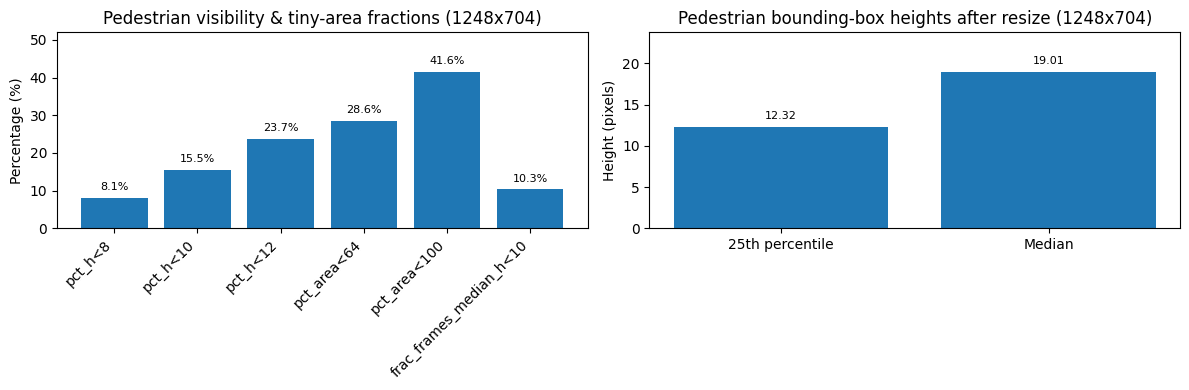

In [13]:
# Visualize pedestrian visibility statistics for 1248x704

row = results_df.loc["1248x704"]

pct_cols = [
    "pct_h<8",
    "pct_h<10",
    "pct_h<12",
    "pct_area<64",
    "pct_area<100",
    "frac_frames_median_h<10",
]
pct_values = [row[c] for c in pct_cols]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# -------- First subplot --------
bars0 = axes[0].bar(range(len(pct_cols)), pct_values)
axes[0].set_xticks(range(len(pct_cols)))
axes[0].set_xticklabels(pct_cols, rotation=45, ha="right")
axes[0].set_ylabel("Percentage (%)")
axes[0].set_title("Pedestrian visibility & tiny-area fractions (1248x704)")

# Add headroom
ymax0 = max(pct_values)
axes[0].set_ylim(0, ymax0 * 1.25)

for bar, v in zip(bars0, pct_values):
    axes[0].annotate(
        f"{v:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 4),  # vertical offset in points
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=8,
    )

# -------- Second subplot --------
height_cols = ["p25_h", "median_h"]
height_values = [row[c] for c in height_cols]

bars1 = axes[1].bar(range(len(height_cols)), height_values)
axes[1].set_xticks(range(len(height_cols)))
axes[1].set_xticklabels(["25th percentile", "Median"])
axes[1].set_ylabel("Height (pixels)")
axes[1].set_title("Pedestrian bounding-box heights after resize (1248x704)")

ymax1 = max(height_values)
axes[1].set_ylim(0, ymax1 * 1.25)

for bar, v in zip(bars1, height_values):
    axes[1].annotate(
        f"{v:.2f}",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 4),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.show()


### **Conclusions**

* **Feasibility of Detection:**
    Pedestrian presence prediction is theoretically feasible for the majority of the dataset. The **median pedestrian height is ~19 pixels**, which places the average target above the "Nyquist folding frequency" (16 pixels) of a standard ResNet50 backbone (Stride=32). This ensures that >50% of pedestrians will map to at least one distinguishable feature vector.

* **Theoretical Performance Cap:**
    The fraction of frames where the median pedestrian height is < 10 pixels is **~10%**. These targets fall significantly below the network's theoretical minimum resolution (16px), meaning they are likely mathematically indistinguishable from aliasing artifacts or noise. Consequently, the **maximum theoretical recall** for a camera-only ResNet model will likely be capped at **~90%**, as these tiny objects are effectively invisible to the architecture without tiling or super-resolution.

* **Engineering Trade-Off:**
    We select the resolution **1248 × 704** to maximize the number of distinct pedestrians (pushing the median to 19px) while maintaining the full field of view (FOV). This accepts the loss of the bottom ~10% of tiny pedestrians in exchange for **architectural safety** (divisible by 32) and **contextual integrity** (no hard crops on hills).

### Now we create the new dataset ZOD_moe
- pure resize from 3848x2168 -> 1248x704
- adjust geometry (multipoint bounding box coordinates) annotations in original_dataset_path/frame_name/annotations/object_detection.json, for all frames. 
- we will first try on just one frame and visualize the rescaled bounding boxes to ensure they work well. 

coords shape 4x2, 4 points 2 coordinates each: (4, 2)


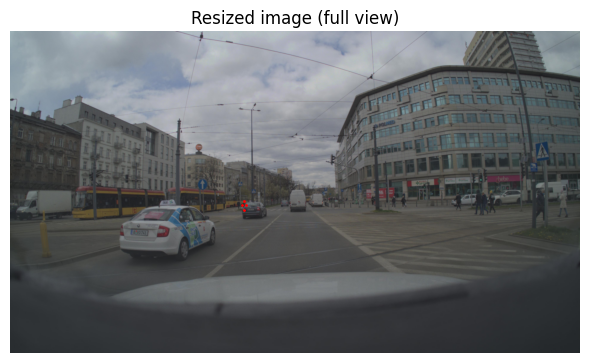

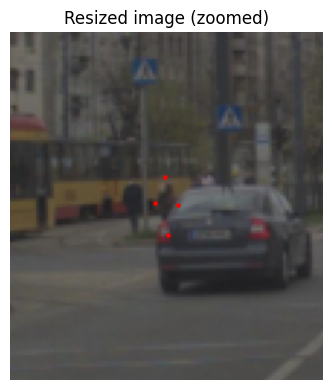

In [16]:
# First we can look at the second frame again (original dataset)
# Path variable: original_obj_det_second_frame
# We resize the image and the multipointbounding boxes accordingly.  

# --- Parameters ---
ORIG_W, ORIG_H = 3848, 2168
NEW_W, NEW_H = 1248, 704   # or whatever resize you decided on

#sx, sy: scaling factors for x and y coordinates
sx = NEW_W / ORIG_W
sy = NEW_H / ORIG_H

#We extract the DNAT image from the ORIGINAL_DNAT_DIR:
img_files = sorted(ORIGINAL_DNAT_DIR.glob("*.jpg"))

# Keep only non-resized images
img_files = [p for p in img_files if "resized" not in p.name.lower()]

assert len(img_files) == 1, f"Expected exactly one original image, found {len(img_files)}"

original_img_path = img_files[0]

# --- Load image ---
img = Image.open(original_img_path).convert("RGB")
img_resized = img.resize((NEW_W, NEW_H), resample=Image.BILINEAR)

# --- Find first pedestrian ---
first_ped = None
for obj in original_obj_det_second_frame:
    if obj.get("properties", {}).get("class") == "Pedestrian":
        first_ped = obj
        break

assert first_ped is not None, "No pedestrian found in this frame"

# --- Extract multipoint coordinates ---
# coords is a list of 4 lists, each containing the x and y coordinates of a point
coords = first_ped["geometry"]["coordinates"]
# we convert the list of lists to a numpy array
coords = np.array(coords, dtype=np.float32)

# --- Resize coordinates ---
coords_resized = np.zeros_like(coords)
print(f"coords shape 4x2, 4 points 2 coordinates each: {coords_resized.shape}")

# we resize the x and y coordinates according to their respective scaling factors
coords_resized[:, 0] = coords[:, 0].copy() * sx
coords_resized[:, 1] = coords[:, 1].copy() * sy

# --- Visualization: RESIZED image (FULL VIEW) ---

plt.figure(figsize=(6, 4))
plt.imshow(img_resized)
plt.scatter(
    coords_resized[:, 0],
    coords_resized[:, 1],
    c="red",
    s=1,
    label="Pedestrian keypoints"
)
plt.title("Resized image (full view)")
plt.axis("off")
plt.tight_layout()
plt.show()


# --- Visualization: RESIZED image (ZOOMED VIEW) ---

# --- Compute zoom bounds in RESIZED coordinates ---
pad = 50  # pixels of padding around the pedestrian

xmin = coords_resized[:, 0].min() - pad
xmax = coords_resized[:, 0].max() + pad
ymin = coords_resized[:, 1].min() - pad
ymax = coords_resized[:, 1].max() + pad

# Clamp to image bounds (important for safety)
xmin = max(0, xmin)
ymin = max(0, ymin)
xmax = min(NEW_W, xmax)
ymax = min(NEW_H, ymax)


plt.figure(figsize=(6, 4))
plt.imshow(img_resized)
plt.scatter(
    coords_resized[:, 0],
    coords_resized[:, 1],
    c="red",
    s=5,
    label="Pedestrian keypoints"
)
plt.xlim(xmin, xmax)
plt.ylim(ymax, ymin)  # inverted y-axis
plt.title("Resized image (zoomed)")
plt.axis("off")
plt.tight_layout()
plt.show()


We've created a script *build_ZOD_moe_parquet.py* that does the following:
- resizes & stores images in "outputs/ZOD_moe/images"
- resizes the multipoint coordinates as in the example above
- includes all other relevant metadata
- includes labels derived from metadata. 
-> exports to parquet file, which will later be further processed via stratified split to train/val/test csv files. 

## Prediction task for camera-only baseline

- Option A: Binary pedestrian presence likely too simple... Likely highly imbalanced (mostly 1s). Not very informative in dense urban scenes.
- Option B: Pedestrian count (regression or classification)
    - Much richer signal
    - Still avoids geometry headaches
- Option C: Thresholded presence (“crowdedness”)
    - ex: 0: none, 1: few (1–5), 2: many (6–15), 3: crowded (16+). 

- to make a decision here, we'd like some global statistics on pedestrian counts across all frames.

In [ ]:
#Pedestrian counts per frame:
counts = []

# Get all frame directories (e.g. "000000", "000001", ...)
frame_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])

total_frames = len(frame_dirs)
print("Total number of frames:", total_frames)

for frame_dir in frame_dirs:
    ann_path = frame_dir / "annotations" / "object_detection.json"
    
    # Skip frames without annotations (safety)
    if not ann_path.exists():
        continue
    
    obj_det = read_json(ann_path)
    
    # Count pedestrians in this frame
    num_peds = sum(
        obj["properties"].get("class") == "Pedestrian"
        for obj in obj_det
    )
    
    counts.append(num_peds)

print("Frames processed:", len(counts))


Total number of frames: 100000
Frames processed: 100000


In [24]:
counts_np = np.array(counts)

print("Pedestrian count statistics:")
print("  Min:", counts_np.min())
print("  Max:", counts_np.max())
print("  Mean:", counts_np.mean())
print("  Median:", np.median(counts_np))

num_zero = np.sum(counts_np == 0)
print("Frames with ZERO pedestrians:", num_zero)
print("Fraction with ZERO pedestrians:", num_zero / len(counts_np))


Pedestrian count statistics:
  Min: 0
  Max: 137
  Mean: 3.59177
  Median: 1.0
Frames with ZERO pedestrians: 41013
Fraction with ZERO pedestrians: 0.41013


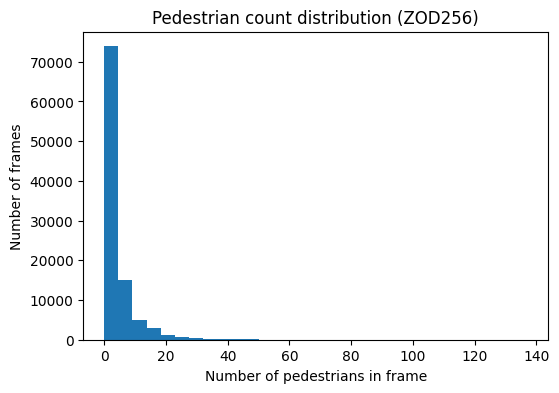

In [25]:
# Pedestrian count distribution:
plt.figure(figsize=(6, 4))
plt.hist(counts_np, bins=30)
plt.xlabel("Number of pedestrians in frame")
plt.ylabel("Number of frames")
plt.title("Pedestrian count distribution (ZOD256)")
plt.show()


In [26]:
def bin_count(n):
    if n == 0:
        return "0"
    elif n <= 5:
        return "1–5"
    elif n <= 15:
        return "6–15"
    else:
        return "16+"

binned = Counter(bin_count(n) for n in counts_np)
print("Binned pedestrian counts:")
for k, v in binned.items():
    print(f"  {k}: {v}")


Binned pedestrian counts:
  16+: 4525
  6–15: 17181
  1–5: 37281
  0: 41013


### Observations:
- Pedestrian presence is not trivial. 
    - ~41% of frames have zero pedestrians
    - ~59% have at least one pedestrian
    → well balanced for a presence task.
- There is a strong long tail:
    - Some frames have very large crowds (up to 100+)
    - Raw regression on counts would be noisy and unstable
- bins are surprisingly well balanced:
    - No bin dominates completely
    - Even 16+ has ~4.5% of data → enough to learn from

OVERALL ASSESSMENT
- Full 2D detection:
    - Requires geometry alignment
    - Heavy engineering
    - Not necessary for research question

- Raw pedestrian count regression:
    - Highly skewed
    - Sensitive to annotation noise
    - Harder to interpret
    → Possible, but not ideal

- Binary pedestrian presence: 
    - balanced, valid choice. 

- Binned pedestrian count (0 | 1–5 | 6–15 | 16+):
    - semantically meaningful (“none”, “few”, “many”, “crowded”)
    - robust to annotation noise
    - well balanced enough to train
    - Uses annotation density information
    - far richer than binary presence
    - Likely best choice. 

- 0 pedestrians → background-dominant scenes
- 1–5 → isolated interactions
- 6–15 → dense urban traffic
- 16+ → crowd scenes, occlusions, clutter


We frame pedestrian perception as a frame-level classification problem, predicting binned pedestrian counts (0, 1–5, 6–15, 16+).

In [ ]:
### CREATE BINNED PEDESTRIAN COUNT LABELS
label_per_frame = {}

for frame_dir in frame_dirs:
    frame_id = frame_dir.name  # e.g. "000000"
    obj_det = read_json(frame_dir / "annotations" / "object_detection.json")
    num_peds = sum(obj["properties"].get("class") == "Pedestrian" for obj in obj_det)
    label_per_frame[frame_id] = bin_count(num_peds)

# --> during training:
y = label_per_frame[frame_id]


## Weather conditions analysis:

In [ ]:
weather_values = []

# Get all frame IDs
frame_ids = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])

total_frames = len(frame_ids)

for fid in frame_ids:
    meta = read_json(DATA_ROOT / fid / "metadata.json")
    weather_values.append(meta.get("scraped_weather", None))

# Count weather occurrences
weather_counts = Counter(weather_values)

print(f"Total frames scanned: {total_frames}")
print("Weather distribution:")

for w, cnt in weather_counts.most_common():
    percentage = 100.0 * cnt / total_frames
    print(f" - {w}: {cnt} ({percentage:.2f}%)")


Total frames scanned: 100000
Weather distribution:
 - partly-cloudy-day: 29153 (29.15%)
 - cloudy: 18991 (18.99%)
 - clear-day: 16441 (16.44%)
 - rain: 15716 (15.72%)
 - partly-cloudy-night: 11124 (11.12%)
 - clear-night: 3999 (4.00%)
 - fog: 2117 (2.12%)
 - snow: 1972 (1.97%)
 - wind: 487 (0.49%)


### Pedestrian bounding-box size distribution
- measure of distribution of pedestrian distance across frames dataset

In [ ]:
# load object_detection.json for one frame (000000)
obj_det_path = first_frame_dir / "annotations" / "object_detection.json"
obj_det = read_json(obj_det_path)   # list of dicts

# find the first pedestrian object ---
ped_obj = None
for obj in obj_det:
    if obj["properties"].get("class") == "Pedestrian":
        ped_obj = obj
        break

print("Found pedestrian:", ped_obj is not None)

# extract the 4 bbox corner points
corners = ped_obj["geometry"]["coordinates"]
print("Corners (4 points):", corners)

# compute xmin/xmax/ymin/ymax ---
xs = [p[0] for p in corners]
ys = [p[1] for p in corners]

xmin, xmax = min(xs), max(xs)
ymin, ymax = min(ys), max(ys)

width  = xmax - xmin
height = ymax - ymin

print("xmin, ymin, xmax, ymax:", xmin, ymin, xmax, ymax)
print("width, height:", width, height)


Found pedestrian: True
Corners (4 points): [[1610.16, 1102.42], [1615.43, 1112.06], [1610.85, 1132.92], [1604.43, 1112.06]]
xmin, ymin, xmax, ymax: 1604.43 1102.42 1615.43 1132.92
width, height: 11.0 30.5


### Pedestrian occlusion distribution

In [ ]:
# Goal: compute a dataset-level "occlusion distribution" for Pedestrian objects
#
# We will scan ALL frames under DATA_ROOT, load each frame's object_detection.json,
# filter to objects with properties["class"] == "Pedestrian", then count how often
# each occlusion_ratio value occurs.
#
# Why do this?
# - It tells us how "hard" the pedestrian labels are (occluded pedestrians are harder).
# - It helps decide whether to include/exclude ambiguous ("unclear") annotations.



# ----------------------------
# Helper: identify pedestrians
# ----------------------------
def is_pedestrian(obj):
    """Return True if this annotation is a Pedestrian object."""
    return obj.get("properties", {}).get("class") == "Pedestrian"

# ----------------------------
# Scan frames and collect occlusion stats
# ----------------------------
occ_all = Counter()          # occlusion counts for ALL pedestrians (including unclear)
occ_clear = Counter()        # occlusion counts for pedestrians with unclear == False
missing_occ_all = 0          # count pedestrians with missing occlusion_ratio field
missing_occ_clear = 0

num_frames_seen = 0
num_frames_missing_ann = 0

num_peds_all = 0
num_peds_clear = 0

# List all frame directories (e.g., 000000, 000001, ...)
frame_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])
print("Total frame folders found:", len(frame_dirs))

for frame_dir in frame_dirs:
    ann_path = frame_dir / "annotations" / "object_detection.json"

    # If a frame doesn't have annotations, skip it (but keep count)
    if not ann_path.exists():
        num_frames_missing_ann += 1
        continue

    num_frames_seen += 1

    # Load annotation list (each element is one object dict)
    obj_det = read_json(ann_path)

    # Filter only pedestrian objects
    peds = [obj for obj in obj_det if is_pedestrian(obj)]

    for obj in peds:
        props = obj.get("properties", {})

        # ---- All pedestrians ----
        num_peds_all += 1
        occ = props.get("occlusion_ratio", None)
        if occ is None:
            missing_occ_all += 1
            occ_all["(missing)"] += 1
        else:
            occ_all[str(occ)] += 1  # cast to str so keys are consistent

        # ---- "Clear" pedestrians (unclear == False) ----
        # If unclear field is missing, .get(..., False) treats it as False
        # (i.e., we assume it's not unclear unless explicitly True)
        is_unclear = props.get("unclear", False)
        if not is_unclear:
            num_peds_clear += 1
            occ_c = props.get("occlusion_ratio", None)
            if occ_c is None:
                missing_occ_clear += 1
                occ_clear["(missing)"] += 1
            else:
                occ_clear[str(occ_c)] += 1

print("\nFrames processed (with annotations):", num_frames_seen)
print("Frames missing object_detection.json:", num_frames_missing_ann)

print("\nTotal pedestrian instances (all):", num_peds_all)
print("Total pedestrian instances (unclear==False):", num_peds_clear)

# ----------------------------
# print results (counts + percentages)
# ----------------------------
def print_counter_as_table(counter, total, title):
    print("\n" + title)
    print("-" * len(title))
    # Sort keys so output is stable/readable
    for k in sorted(counter.keys()):
        v = counter[k]
        pct = (v / total) * 100 if total > 0 else 0.0
        print(f"{k:12s}  {v:8d}  ({pct:6.2f}%)")

print_counter_as_table(
    occ_all,
    num_peds_all,
    title="Pedestrian occlusion_ratio distribution (ALL pedestrians)"
)

print_counter_as_table(
    occ_clear,
    num_peds_clear,
    title="Pedestrian occlusion_ratio distribution (ONLY unclear==False pedestrians)"
)

print("\nMissing occlusion_ratio (ALL):", missing_occ_all)
print("Missing occlusion_ratio (unclear==False):", missing_occ_clear)


Total frame folders found: 100000

Frames processed (with annotations): 100000
Frames missing object_detection.json: 0

Total pedestrian instances (all): 359177
Total pedestrian instances (unclear==False): 318582

Pedestrian occlusion_ratio distribution (ALL pedestrians)
---------------------------------------------------------
(missing)        40595  ( 11.30%)
Heavy            50690  ( 14.11%)
Light            93313  ( 25.98%)
Medium           53826  ( 14.99%)
None            100831  ( 28.07%)
VeryHeavy        19922  (  5.55%)

Pedestrian occlusion_ratio distribution (ONLY unclear==False pedestrians)
-------------------------------------------------------------------------
Heavy            50690  ( 15.91%)
Light            93313  ( 29.29%)
Medium           53826  ( 16.90%)
None            100831  ( 31.65%)
VeryHeavy        19922  (  6.25%)

Missing occlusion_ratio (ALL): 40595
Missing occlusion_ratio (unclear==False): 0


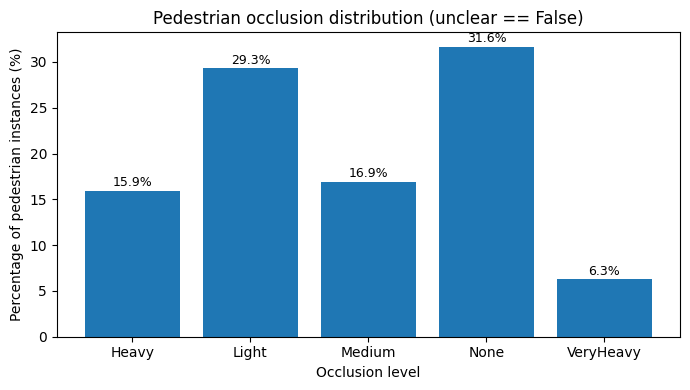

In [30]:
# Use the "clear" pedestrians only (unclear == False)
labels = []
counts = []

for k in sorted(occ_clear.keys()):
    labels.append(k)
    counts.append(occ_clear[k])

total = sum(counts)
percentages = [100 * c / total for c in counts]

plt.figure(figsize=(7, 4))
plt.bar(labels, percentages)
plt.ylabel("Percentage of pedestrian instances (%)")
plt.xlabel("Occlusion level")
plt.title("Pedestrian occlusion distribution (unclear == False)")

# Add percentage labels on top of bars
for i, pct in enumerate(percentages):
    plt.text(i, pct + 0.5, f"{pct:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


In [32]:
# Explicitly verify relationship between 'unclear' and 'occlusion_ratio'

num_unclear_peds = 0
num_unclear_with_occ = 0

for frame_dir in frame_dirs:
    ann_path = frame_dir / "annotations" / "object_detection.json"
    obj_det = read_json(ann_path)

    for obj in obj_det:
        props = obj.get("properties", {})
        if props.get("class") != "Pedestrian":
            continue

        if props.get("unclear", False):
            num_unclear_peds += 1
            if props.get("occlusion_ratio") is not None:
                num_unclear_with_occ += 1

print("Total unclear pedestrian instances:", num_unclear_peds)
print("Unclear pedestrians WITH occlusion label:", num_unclear_with_occ)


Total unclear pedestrian instances: 40595
Unclear pedestrians WITH occlusion label: 0


Each pedestrian instance in ZOD is annotated with a categorical occlusion level (None, Light, Medium, Heavy, VeryHeavy). Above we plot the dataset-level distribution of these occlusion levels for pedestrian annotations. 

In the ZOD256 split used in this work, all pedestrian annotations marked as unclear lack an occlusion label, whereas all clear pedestrian annotations include one. We therefore exclude annotations marked as unclear from the overall occlusion distribution.

- 89% of total pedestrian instances are marked unclear == False.
- Unclear pedestrians ≈ 11% of instances --> including unclear pedestrians is important for robustness. Excluding them would bias toward easy cases. 
- Every unclear pedestrian lacks an occlusion label
- Every clear pedestrian has an occlusion label


Across 100 000 frames, the dataset contains 359 177 pedestrian instances, with approximately 89% marked as clear annotations. Pedestrian occlusion is prevalent, with nearly 40% of pedestrian instances exhibiting medium-to-very heavy occlusion. Rather than filtering such cases, we treat occlusion as an inherent property of real-world urban perception. We frame pedestrian perception as a frame-level classification task, predicting binned pedestrian counts per frame.